# Rain in Australia - Next-Day Prediction Model
---

Student name: T.J. Kyner \
Student pace: Full time \
Instructor: Abhineet Kulkarni \
Cohort: 040521

# Project Overview
---
## Data Source
The data used in this project was downloaded from the Kaggle dataset titled [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package), which itself was originally sourced from the Australian Bureau of Meteorology's [Daily Weather Observations](http://www.bom.gov.au/climate/dwo/). Additional weather metrics for Australia can be found within the bureau's [Climate Data Online](http://www.bom.gov.au/climate/data/) web app.

## Business Problem
Weather, and humankind's ability to accurately predict it, plays a critical role in many aspects of life. From farmers growing crops to a family planning a weekend vacation to logistical decision making within airlines, rain in particular is highly influential regarding plans. In some instances, the impact of rain can have large financial consequences. As a result, there is a strong interest from a plethora of stakeholders in the ability to accurately forecast rain. The goal of this project is to use the available data to create a next-day prediction model for whether or not it will rain. Such a model could be utilized in a weather app for the benefit of the public at large.

# Imports & Settings
---

In [89]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

In [90]:
# Setting the default styling attributes for seaborn
sns.set_theme(style='darkgrid')

In [91]:
# Loading in the dataset
df = pd.read_csv('weatherAUS.csv')

# Exploratory Data Analysis
---

## Data Preview

In [92]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [93]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Column Definitions
According to the author of the Kaggle dataset and the ["Notes to accompany Daily Weather Observations"](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml) published by the Australian Bureau of Meteorology, the meanings and units for each of the columns in the dataset are as follows:

| **Column Name** | **Definition** | **Units** |
| --------------- | -------------- | --------- |
| `Date` | Date of the observation | N/A |
| `Location` | Location of the weather station | N/A |
| `MinTemp` | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `MaxTemp` | Maximum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `Rainfall` | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimeter | Millimeters |
| `Evaporation` | "Class A" pan evaporation in the 24 hours to 9am | Millimeters |
| `Sunshine` | Bright sunshine in the 24 hours to midnight | Hours |
| `WindGustDir` | Direction of the strongest wind gust in the 24 hours to midnight | 16 compass points |
| `WindGustSpeed` | Speed of the strongest wind gust in the 24 hours to midnight | Kilometers per hour |
| `WindDir9am` | Direction of the wind at 9am | 16 compass points |
| `WindDir3pm` | Direction of the wind at 3pm | 16 compass points |
| `WindSpeed9am` | Speed of the wind at 9am | Kilometers per hour |
| `WindSpeed3pm` | Speed of the wind at 3pm | Kilometers per hour |
| `Humidity9am` | Relative humidity at 9am | Percent |
| `Humidity3pm` | Relative humidity at 3pm | Percent |
| `Pressure9am` | Atmospheric pressure reduced to mean sea level at 9am | Hectopascals |
| `Pressure3pm` | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascals |
| `Cloud9am` | Fraction of sky obscured by cloud at 9am | Eighths |
| `Cloud3pm` | Fraction of sky obscured by cloud at 3pm | Eighths |
| `Temp9am` | Temparature at 9am | Degrees Celsius |
| `Temp3pm` | Temparature at 3am | Degrees Celsius |
| `RainToday` | Did the current day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |
| `RainTomorrow` | Did the next day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |

## Exploration

### Summary Info and Stats
Taking a look at the dataframe info:

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

**Observations:**
- The `Date` column needs converted to a datetime datatype
- The datatypes for all other columns look good as is
- There appears to be a large number of missing values across multiple columns

Looking into the number of missing values per column as a percentage:

In [95]:
round(df.isna().sum() / len(df), 3)

Date             0.000
Location         0.000
MinTemp          0.010
MaxTemp          0.009
Rainfall         0.022
Evaporation      0.432
Sunshine         0.480
WindGustDir      0.071
WindGustSpeed    0.071
WindDir9am       0.073
WindDir3pm       0.029
WindSpeed9am     0.012
WindSpeed3pm     0.021
Humidity9am      0.018
Humidity3pm      0.031
Pressure9am      0.104
Pressure3pm      0.103
Cloud9am         0.384
Cloud3pm         0.408
Temp9am          0.012
Temp3pm          0.025
RainToday        0.022
RainTomorrow     0.022
dtype: float64

**Observations:**
- `Evaporation`, `Sunshine`, `Cloud9am`, and `Cloud3pm` are all missing more than 35% of their values
- Aside from `Date` and `Location`, all columns are missing at least some values
- These missing values can be handled by either dropping certain columns/rows, imputing the values, or a mix of both

Next, taking a look at some summary statistics:

In [96]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


**Observations:**
- Multiple columns have clear outliers (e.g., the max `Rainfall` value is 371.0 despite the 75th percentile being 0.8)
- Not seeing any values that are immediate cause for concern (such as a negative value for minimum `Rainfall`)

In order to get a better feel for the data and catch any placeholder values that may not have shown up in the summary statistics, I also want to check the top five most frequent values for each column.

In [97]:
for col in df.columns:
    print('\n')
    print(col)
    print('-'*15)
    print(df[col].value_counts(normalize=True).head())



Date
---------------
Date
2013-11-12    0.000337
2014-09-01    0.000337
2014-08-23    0.000337
2014-08-24    0.000337
2014-08-25    0.000337
Name: proportion, dtype: float64


Location
---------------
Location
Canberra     0.023622
Sydney       0.022989
Darwin       0.021951
Melbourne    0.021951
Brisbane     0.021951
Name: proportion, dtype: float64


MinTemp
---------------
MinTemp
11.0    0.006244
10.2    0.006237
9.6     0.006223
10.5    0.006140
9.0     0.006057
Name: proportion, dtype: float64


MaxTemp
---------------
MaxTemp
20.0    0.006137
19.0    0.005846
19.8    0.005825
20.4    0.005784
19.9    0.005707
Name: proportion, dtype: float64


Rainfall
---------------
Rainfall
0.0    0.640511
0.2    0.061611
0.4    0.026597
0.6    0.018228
0.8    0.014459
Name: proportion, dtype: float64


Evaporation
---------------
Evaporation
4.0    0.040390
8.0    0.031559
2.2    0.025342
2.0    0.024580
2.4    0.024229
Name: proportion, dtype: float64


Sunshine
---------------
Sunshine
0

**Observations:**
- The value counts of the `Date` column need further explored on a non-normalized basis
- There's a disconnect between the `Rainfall` value counts and the `RainToday` / `RainTomorrow` value counts. While roughly 64% of observations had a value of 0 for `Rainfall`, about 77.5% of days did not have rainfall according to the latter two columns. This discrepency is likely due to differences in the number of missing values for each column
- The `RainToday` and `RainTomorrow` columns should be converted to 0s and 1s for easier manipulation

Further exploring the `Date` column:

In [98]:
df.Date.value_counts()

Date
2013-11-12    49
2014-09-01    49
2014-08-23    49
2014-08-24    49
2014-08-25    49
              ..
2007-11-29     1
2007-11-28     1
2007-11-27     1
2007-11-26     1
2008-01-31     1
Name: count, Length: 3436, dtype: int64

In [99]:
df.Location.nunique()

49

The maximum number of observations for a given date aligns with the number of unique locations within the dataset. This intuitively makes sense because each weather station at the different locations would be reporting their own data for a given day.

Adjusting the `RainToday` and `RainTomorrow` columns:

In [100]:
df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})
df.RainToday.value_counts(normalize=True)

RainToday
0.0    0.775807
1.0    0.224193
Name: proportion, dtype: float64

In [101]:
df.RainTomorrow = df.RainTomorrow.map({'No': 0, 'Yes': 1})
df.RainTomorrow.value_counts(normalize=True)

RainTomorrow
0.0    0.775819
1.0    0.224181
Name: proportion, dtype: float64

### Histograms

Text(0.5, 1.0, 'Histograms of Columns')

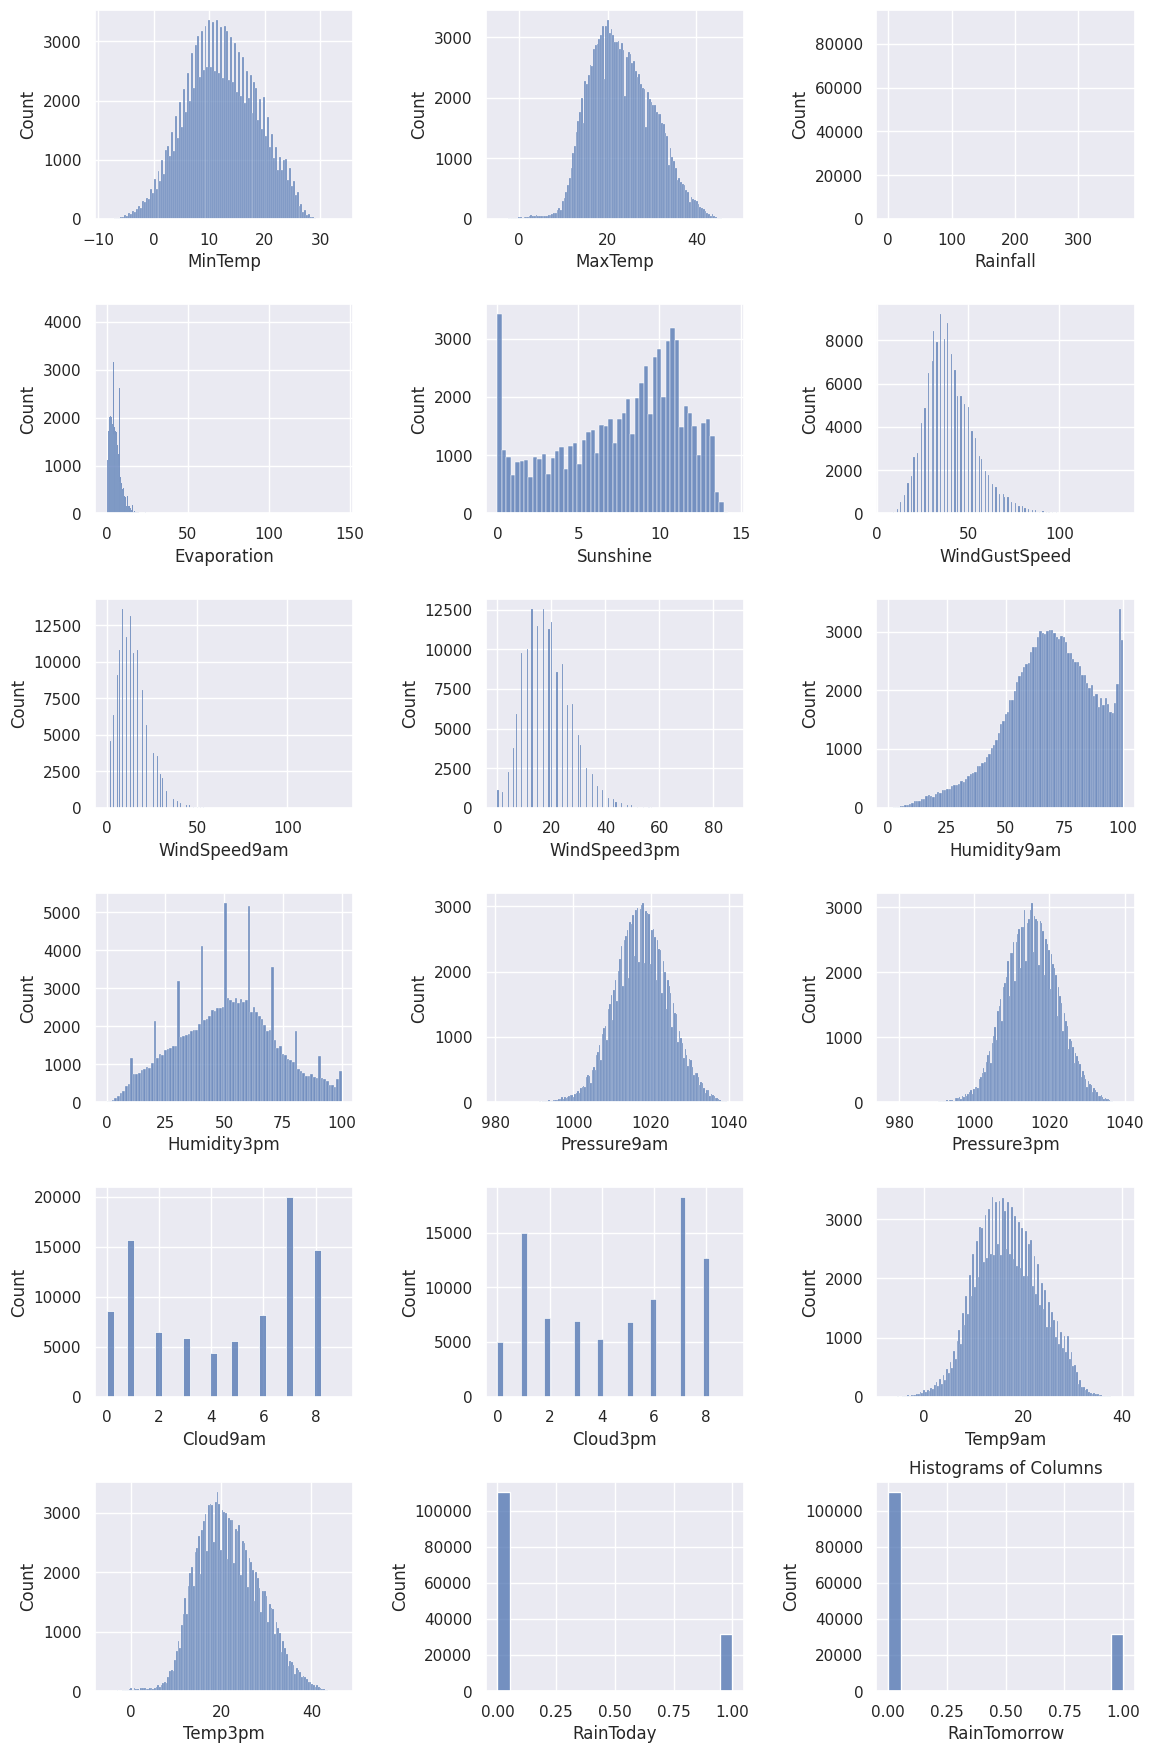

In [102]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 18))
axes = axes.reshape(-1)

continuous = [col for col in df.columns if df[col].dtype != object]
for i, col in enumerate(continuous):
    sns.histplot(df[col], ax=axes[i])

fig.tight_layout(pad=2.0)
plt.title('Histograms of Columns')


**Observations:**
- Most features are normally distributed as expected
- The `Rainfall` distribution needs further investigation as the large outlier is likely affecting the ability to plot the data
- The `Sunshine` distribution is interesting but largely explainable:
    - The high frequency of 0 values represents days where it is overcast all day
    - The abrupt decline in frequency after around 11 hours is a reflection of the limited number of days of the year where it is light out for that many hours or longer
- The `Humidity9am` distribution is particularly interesting due to the large spike in frequencies near 100%

Since the summary statistics section showed that the 75th percentile for the `Rainfall` feature is only 0.8, the following plot shows the distribution of values betwen 0 and 1.

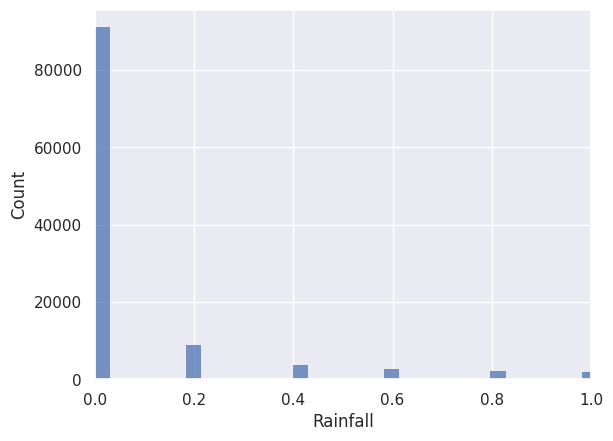

In [103]:
sns.histplot(df.Rainfall)
plt.xlim(0, 1);

### Rainy Days by Location

In [104]:
df_rain_by_loc = df.groupby(by='Location').sum()
df_rain_by_loc = df_rain_by_loc[['RainToday']]
df_rain_by_loc.head()

,RainToday
Location,
Adelaide,689.0
Albany,902.0
Albury,617.0
AliceSprings,244.0
BadgerysCreek,583.0


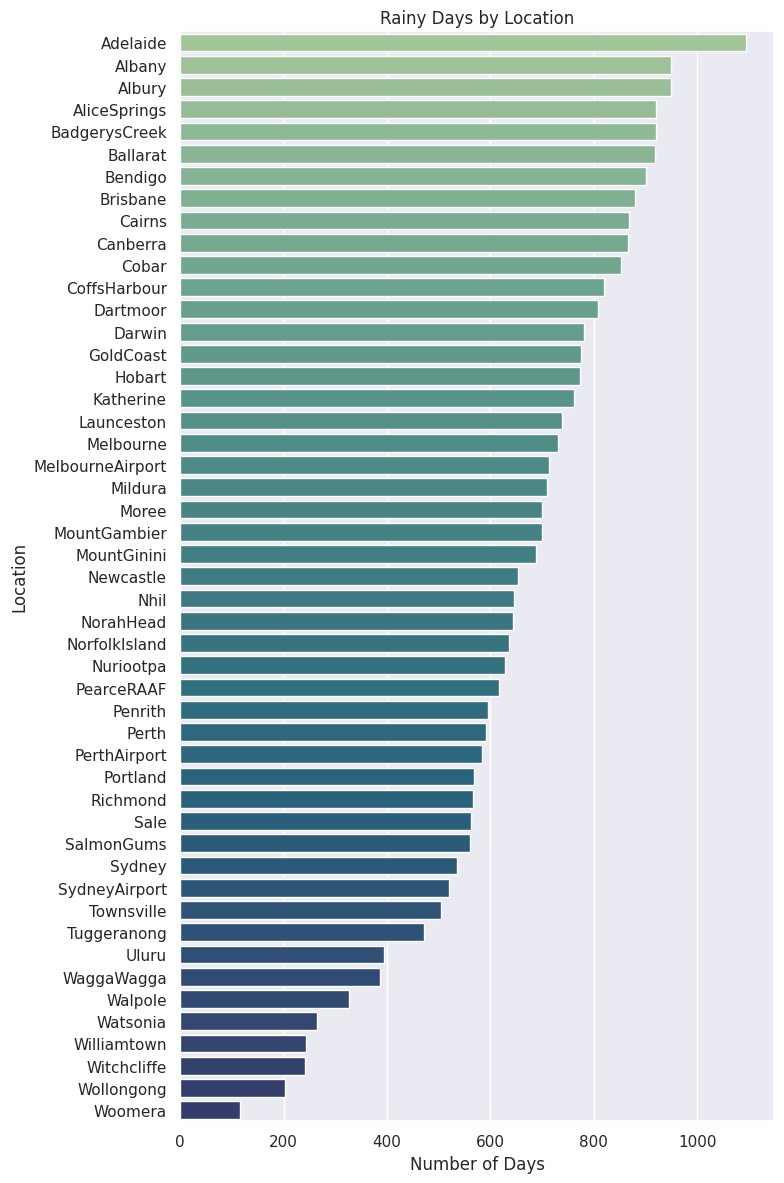

In [105]:
plt.figure(figsize=(8, 12))
sns.barplot(x='RainToday',
            y=df_rain_by_loc.index,
            data=df_rain_by_loc.sort_values('RainToday', ascending=False),
            orient='h',
            palette='crest'
           )
plt.xlabel('Number of Days')
plt.title('Rainy Days by Location')
plt.tight_layout()

The above chart is useful for a quick check on the differences between locations with regard to the number of rainy days but suffers from one key issue: the number of observations from each location is not exactly the same. Checking the value counts for each location (below) reveals that the locations of `Katherine`, `Nhil`, and `Uluru` should be ignored when analyzing the above plot. The remaining locations have value counts that are close enough to be properly comparable.

In [106]:
df.Location.value_counts()

Location
Canberra            3436
Sydney              3344
Darwin              3193
Melbourne           3193
Brisbane            3193
Adelaide            3193
Perth               3193
Hobart              3193
Albany              3040
MountGambier        3040
Ballarat            3040
Townsville          3040
GoldCoast           3040
Cairns              3040
Launceston          3040
AliceSprings        3040
Bendigo             3040
Albury              3040
MountGinini         3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
Woomera             3009
Nuriootpa           3009
Cobar               3009
CoffsHarbour        3009
Moree               3009
Sale                3009
PerthAirport        3009
PearceRAAF          3009
Witchcliffe         3009
BadgerysCreek       3009
Mildura             3009
NorfolkIsland       3009
MelbourneAirport    3009
Richmond            3009
SydneyAirport       3009
WaggaWagga          3009
Williamtown     

# Data Preprocessing
---

## Missing Values
The primary preprocessing need for this dataset is handling the missing values. Given the strong correlations between certain features, using a multivariate feature imputation method makes sense. While still experimental, the `IterativeImputer` module from `sklearn` is perfect for this use case and appears stable enough. This module...
> "...models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned."

Source: [6.4.3. Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#iterative-imputer)

I do not want to impute values for the target variable (`RainTomorrow`) since this will detract from the ground truth and have potential negative effects on the model. To start, I'll drop rows in which the `RainTomorrow` value is missing.

In [134]:
df_imputed = df.dropna(axis=0, subset=['RainTomorrow'])
df_imputed.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

### Continuous Features
For the continuous features, I'll apply the `IterativeImputer`.

In [135]:
cont_feats = [col for col in df_imputed.columns if df_imputed[col].dtype != object]
cont_feats.remove('RainTomorrow')
cont_feats

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [136]:
imputer = IterativeImputer(random_state=42)
df_imputed_cont = imputer.fit_transform(df_imputed[cont_feats])
df_imputed_cont = pd.DataFrame(df_imputed_cont, columns=cont_feats)
df_imputed_cont.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,6.497888,7.048211,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,5.103048,16.9,21.8,0.0
1,7.4,25.1,0.0,6.270412,10.863393,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.912027,2.640581,17.2,24.3,0.0
2,12.9,25.7,0.0,8.659380,11.812408,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.014404,2.000000,21.0,23.2,0.0
3,9.2,28.0,0.0,6.764941,11.542532,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,1.201990,1.993914,18.1,26.5,0.0
4,17.5,32.3,1.0,7.455971,5.520080,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0


In [137]:
df_imputed_cont.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

### Categorical Features
For the categorical features, I'll be replacing the missing values with a randomly chosen option from the unique values of each feature according to their probability distribution.

In [138]:
# List of categorical features excluding continuous features
cat_feats = [col for col in df_imputed.columns if col not in cont_feats]

# Remove 'RainTomorrow', 'Date', and 'Location' if they exist in the list
for col in ['RainTomorrow', 'Date', 'Location']:
    if col in cat_feats:
        cat_feats.remove(col)

# Display the list of categorical features
cat_feats

['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [139]:
df_imputed_cat = df_imputed[cat_feats].copy()

for col in df_imputed_cat.columns:
    # Get the unique values and their probabilities for the current column
    values = df_imputed_cat[col].value_counts().index.values
    probs = df_imputed_cat[col].value_counts(normalize=True).values

    # Replace NaN values with a randomly chosen value based on the distribution
    df_imputed_cat[col] = df_imputed_cat[col].apply(
        lambda x: np.random.choice(values, p=probs) if pd.isnull(x) else x
    )

df_imputed_cat.head()


,WindGustDir,WindDir9am,WindDir3pm
0,W,W,WNW
1,WNW,NNW,WSW
2,WSW,W,WSW
3,NE,SE,E
4,W,ENE,NW


In [140]:
df_imputed_cat.isna().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

### Concatenating
Now that the missing values have been handled, I need to place all of the separated dataframes back together into one final dataframe.

In [141]:
df_date_loc = df_imputed[['Date', 'Location']]
df_target = df_imputed.RainTomorrow

print(df_date_loc.shape)
print(df_imputed_cont.shape)
print(df_imputed_cat.shape)
print(df_target.shape)

(142193, 2)
(142193, 17)
(142193, 3)
(142193,)


In [142]:
df_imputed_final = pd.concat(objs=[df_date_loc.reset_index(drop=True),
                                   df_imputed_cont.reset_index(drop=True),
                                   df_imputed_cat.reset_index(drop=True),
                                   df_target.reset_index(drop=True)
                                  ],
                             axis=1
                            )
df_imputed_final.shape

(142193, 23)

In [143]:
df_imputed_final.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,6.497888,7.048211,44.0,20.0,24.0,...,1007.1,8.000000,5.103048,16.9,21.8,0.0,W,W,WNW,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,6.270412,10.863393,44.0,4.0,22.0,...,1007.8,1.912027,2.640581,17.2,24.3,0.0,WNW,NNW,WSW,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,8.659380,11.812408,46.0,19.0,26.0,...,1008.7,2.014404,2.000000,21.0,23.2,0.0,WSW,W,WSW,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,6.764941,11.542532,24.0,11.0,9.0,...,1012.8,1.201990,1.993914,18.1,26.5,0.0,NE,SE,E,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,7.455971,5.520080,41.0,7.0,20.0,...,1006.0,7.000000,8.000000,17.8,29.7,0.0,W,ENE,NW,0.0


A quick check to ensure all missing values have been handled:

In [144]:
df_imputed_final.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
WindGustDir      0
WindDir9am       0
WindDir3pm       0
RainTomorrow     0
dtype: int64

## Extracting the Month
As seen in the EDA section, rainfall in Australia exhibits seasonality. Instead of using the full date from the `Date` column, extracting just the month is much more valuable.

In [145]:
df_month = df_imputed_final.copy()
df_month.insert(1, 'Month', df_month.Date.apply(lambda x: int(str(x)[5:7])))
df_month.drop(columns='Date', inplace=True)
df_month.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,12,Albury,13.4,22.9,0.6,6.497888,7.048211,44.0,20.0,24.0,...,1007.1,8.000000,5.103048,16.9,21.8,0.0,W,W,WNW,0.0
1,12,Albury,7.4,25.1,0.0,6.270412,10.863393,44.0,4.0,22.0,...,1007.8,1.912027,2.640581,17.2,24.3,0.0,WNW,NNW,WSW,0.0
2,12,Albury,12.9,25.7,0.0,8.659380,11.812408,46.0,19.0,26.0,...,1008.7,2.014404,2.000000,21.0,23.2,0.0,WSW,W,WSW,0.0
3,12,Albury,9.2,28.0,0.0,6.764941,11.542532,24.0,11.0,9.0,...,1012.8,1.201990,1.993914,18.1,26.5,0.0,NE,SE,E,0.0
4,12,Albury,17.5,32.3,1.0,7.455971,5.520080,41.0,7.0,20.0,...,1006.0,7.000000,8.000000,17.8,29.7,0.0,W,ENE,NW,0.0


## Dummy Variables
All categorical features now need transformed into dummy variables in order to be useable in the modeling section.

In [146]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies = pd.get_dummies(df_month, columns=categoricals)
df_dummies.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,6.497888,7.048211,44.0,20.0,24.0,71.0,22.0,...,False,False,False,False,False,False,False,False,True,False
1,7.4,25.1,0.0,6.270412,10.863393,44.0,4.0,22.0,44.0,25.0,...,False,False,False,False,False,False,False,False,False,True
2,12.9,25.7,0.0,8.659380,11.812408,46.0,19.0,26.0,38.0,30.0,...,False,False,False,False,False,False,False,False,False,True
3,9.2,28.0,0.0,6.764941,11.542532,24.0,11.0,9.0,45.0,16.0,...,False,False,False,False,False,False,False,False,False,False
4,17.5,32.3,1.0,7.455971,5.520080,41.0,7.0,20.0,82.0,33.0,...,False,True,False,False,False,False,False,False,False,False


In [147]:
df_dummies.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW'],
      dtype='object', length=127)

# Modeling Training

---

In [148]:
df_final = df_dummies.copy()
X = df_final.drop(columns='RainTomorrow')
y = df_final.RainTomorrow

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 106644
Test size:  35549


Neural Network

In [149]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the neural network model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.8347632844805761
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     27623
         1.0       0.64      0.60      0.62      7926

    accuracy                           0.83     35549
   macro avg       0.76      0.75      0.76     35549
weighted avg       0.83      0.83      0.83     35549



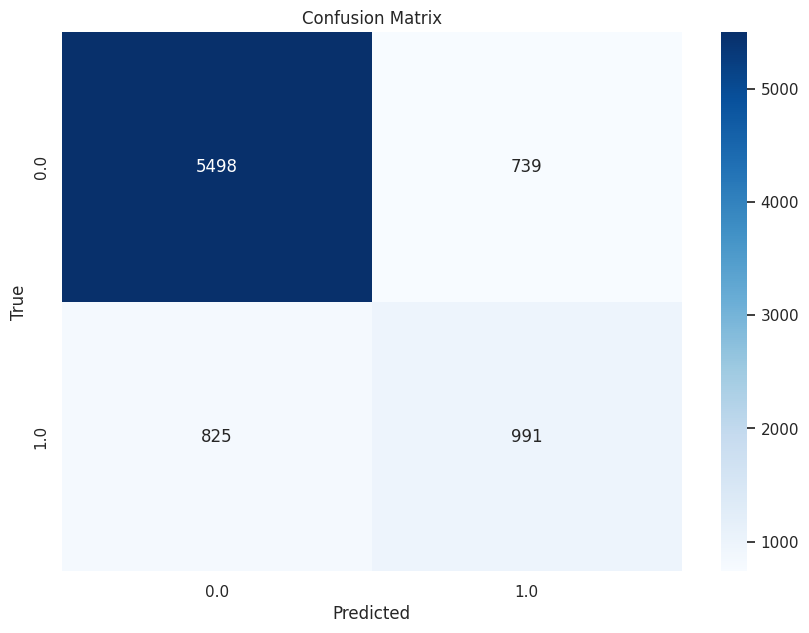

In [80]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Conclusion
---

## Results
The best performing model is the hyperparameter-tuned XGBoost model with an accuracy of approximately 86%. The scores for both the training and testing data were similar, reducing concerns of the model being overfit. In terms of feature importances, `Humidity3pm` is the single most important feature. However, when grouping the features back into their original categories, the following groups have the most importance:
- `Location`
- `WindDir3pm`
- `WindDir9am`
- `WindGustDir`
- `Month`
- `Humidity3pm`

## Next Steps
While this model is a good starting point for rain prediction in Australia, there are several ways in which the model could be improved upon:
- Further hyperparameter tuning
- Engineering new features such as trailing amounts of rain or sunshine
- Collecting additional data from nearby countries (for example, does rain originating in Indonesia or New Zealand have predictive power?)
- Attempting to predict the *amount* of rainfall